# Momentum budget : perturbations
Close the depth integrated, time averaged perturbation momentum budgets over the Bering/Chukchi Sea region.

In [1]:
from glob import glob
import subprocess
import xarray as xr
import matplotlib.pyplot as plt
plt.rcParams.update({'font.size': 16})
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import cmocean
import numpy as np
from xgcm import Grid
import warnings
warnings.filterwarnings('ignore')

## Read in model data
load terms for the depth-averaged y-momentum budget

In [2]:
terms = ['hf_dvdt_2d', 'hf_CAv_2d', 'hf_rvxu_2d', 'hf_gKEv_2d',
         'hf_PFv_2d', 'hf_v_BT_accel_2d', 'hf_diffv_2d',
         'hf_dv_dt_visc_2d', 'tauy', 'tauy_bot']

In [3]:
def open_data(exp):
    base = '/archive/Marion.Alberty/FMS2021.02_mom6_devgfdl_20221223/OM4p25_JRA55do1.4_0netfw_cde.02_BWP_'
    # file list
    pp = '/gfdl.ncrc4-intel18-prod/pp/ocean_monthly/ts/monthly/*yr/'
    flist = glob(f'{base}{exp}{pp}../../../*.static.nc')
    for term in terms:
        flist += glob(f'{base}{exp}{pp}*.{term}.nc')
    
    # dmget files
    _ = subprocess.run(["dmget"]+flist, check=True)
    
    # open model data
    v2drop = ['average_DT', 'average_T1', 'average_T2','time_bnds']
    DS = xr.open_mfdataset(flist,use_cftime=True,combine='by_coords',engine='netcdf4',
                           drop_variables=v2drop)
    
    DS = DS.assign_coords({'geolon': DS['geolon'], 'geolat': DS['geolat'],
                           'geolon_u': DS['geolon_u'], 'geolat_u': DS['geolat_u'],
                           'geolon_v': DS['geolon_v'], 'geolat_v': DS['geolat_v'],
                           'geolon_c': DS['geolon_c'], 'geolat_c': DS['geolat_c']})
    
    return DS

## Calculate the perturbation response
For the perturbation experiment and control run, take the difference between the two experiments and take the time average.

In [4]:
def calc_pert(exp):
    # get datasets
    EXP = open_data(exp)
    CTRL = open_data('ctrl')
    
    # responses
    DS = xr.Dataset()
    for term in terms:
        DS[term] = EXP[term] - CTRL[term]
    
    # time average
    DS = DS.where(DS.time.dt.month>=3).mean('time')
    
    # add deptho
    DS['deptho'] = CTRL['deptho']
    
    return DS.load()

## Plot terms

In [5]:
def plot_map(ax, da, vmin=-999, vmax=999, vstep=1,
             lon='geolon', lat='geolat', cmap='RdBu_r', title='what is it?'):

    contours = np.arange(vmin, vmax+vstep, vstep)
    
    # data projection
    crs = ccrs.PlateCarree()

    p = da.plot(ax=ax, x=lon, y=lat, vmin=vmin, vmax=vmax, cmap=cmap,
                transform=crs, add_labels=False,
                add_colorbar=False, rasterized=True)

    # add separate colorbar
    cb = plt.colorbar(p, ax=ax, format='%.1e', extend='both', shrink=0.6)
    cb.ax.tick_params(labelsize=12)

    p.axes.gridlines(color='black', alpha=0.5, linestyle='--')

    ax.set_title(title, fontsize=14)
    
     # Zoom in around Bering Strait
    ax.set_extent([-190,-150,55,80],crs=crs)

    # Add a land mask and coastlines
    ax.add_feature(cfeature.LAND,zorder=9,facecolor='darkgray')
    ax.coastlines()
    
    return

def plot_pert_budget(DS):
    # Meridional perturbation Momentum budget (units are in m/s2)
    max_r = 5e-6

    fig, ax = plt.subplots(ncols=2,nrows=3,figsize=(14,20),
                           subplot_kw={'projection':ccrs.LambertConformal(central_longitude=-170)})

    plot_map(ax[0,0], DS['hf_dvdt_2d'], vmin=-1e-2*max_r, vmax=1e-2*max_r, vstep=2.e-3*max_r,
             lon='geolon_v', lat='geolat_v', cmap='RdBu_r', title='Tendency (hf_dvdt_2d)')

    plot_map(ax[0,1], DS['hf_CAv_2d'], vmin=-max_r, vmax=max_r, vstep=2.e-1*max_r,
             lon='geolon_v', lat='geolat_v', cmap='RdBu_r', title='Cor. Adv. Accel. (hf_CAv_2d)')

    plot_map(ax[1,0], DS['hf_dv_dt_visc_2d'], vmin=-max_r, vmax=max_r, vstep=2.e-3*max_r,
             lon='geolon_v', lat='geolat_v', cmap='RdBu_r', title='Stress + Fric. Accel. (hf_dv_dt_visc_2d)')

    plot_map(ax[1,1], DS['hf_PFv_2d']+DS['hf_v_BT_accel_2d'], vmin=-max_r, vmax=max_r, vstep=2.e-1*max_r,
             lon='geolon_v', lat='geolat_v', cmap='RdBu_r', title='Pres. Accel. (hf_PFv_2d + hf_v_BT_accel_2d)')

    plot_map(ax[2,0], DS['hf_diffv_2d'], vmin=-1e-2*max_r, vmax=1e-2*max_r, vstep=2.e-3*max_r,
             lon='geolon_v', lat='geolat_v', cmap='RdBu_r', title='Hori. Visc. Accel. (hf_diffv_2d)')

    tmp = DS['hf_dvdt_2d']-DS['hf_CAv_2d']-DS['hf_PFv_2d']-DS['hf_diffv_2d']-DS['hf_dv_dt_visc_2d']-DS['hf_v_BT_accel_2d']
    plot_map(ax[2,1], tmp, vmin=-1e-2*max_r, vmax=1e-2*max_r, vstep=2.e-3*max_r,
             lon='geolon_v', lat='geolat_v', cmap='RdBu_r', title='Vertical remapping term')
    return fig

def plot_pert_stress(DS):
    # decompose the Stress + Fric. Accel into surface stress, bottom stress, and vertical friction
    grid = Grid(DS, coords={'X': {'center': 'xh', 'right': 'xq'},
                            'Y': {'center': 'yh', 'right': 'yq'} }, periodic=['X'])

    # H should be equal to ocean depth + SSH. For the purpose for demonstration, we use ocean depth only.
    H = grid.interp(DS.deptho, 'Y',  boundary='fill')

    F_vy = H * 1035. * DS['hf_dv_dt_visc_2d'] - (DS['tauy'] - DS['tauy_bot'])

    max_r = 1e-1

    fig, ax = plt.subplots(ncols=3,nrows=1,figsize=(21,8),
                           subplot_kw={'projection':ccrs.LambertConformal(central_longitude=-170)})

    plot_map(ax[0], F_vy, vmin=-max_r, vmax=max_r, vstep=2.e-1*max_r,
             lon='geolon_v', lat='geolat_v', cmap='RdBu_r', title='$\mathcal{F}_x^{vf}$')

    plot_map(ax[1], DS['tauy'], vmin=-max_r, vmax=max_r, vstep=2.e-1*max_r,
             lon='geolon_v', lat='geolat_v', cmap='RdBu_r', title='Surf. Stress (tauy)')

    plot_map(ax[2], -DS['tauy_bot'], vmin=-max_r, vmax=max_r, vstep=2.e-1*max_r,
             lon='geolon_v', lat='geolat_v', cmap='RdBu_r', title='Bot. Stress (-tauy_bot)')
    return fig

def plot_pert_CorPres(DS):
    max_r = 5e-6

    fig, ax = plt.subplots(ncols=3,nrows=3,figsize=(21,21),
                           subplot_kw={'projection':ccrs.LambertConformal(central_longitude=-170)})

    plot_map(ax[0,0], DS['hf_CAv_2d']-DS['hf_gKEv_2d']-DS['hf_rvxu_2d'], vmin=-max_r, vmax=max_r, vstep=2.e-1*max_r,
             lon='geolon_v', lat='geolat_v', cmap='RdBu_r', title='Lin. Cor. Adv. Accel. (hf_CAv_2d - hf_rvxu_2d - hf_gKEv_2d)')

    plot_map(ax[0,1], DS['hf_rvxu_2d'], vmin=-max_r, vmax=max_r, vstep=2.e-1*max_r,
             lon='geolon_v', lat='geolat_v', cmap='RdBu_r', title='Nonlin. Cor. Adv. Accel. (hf_rvxu_2d)')

    plot_map(ax[0,2], DS['hf_gKEv_2d'], vmin=-max_r, vmax=max_r, vstep=2.e-1*max_r,
             lon='geolon_v', lat='geolat_v', cmap='RdBu_r', title='KE Accel. (hf_gKEv_2d)')


    plot_map(ax[1,0], DS['hf_CAv_2d'], vmin=-max_r, vmax=max_r, vstep=2.e-1*max_r,
             lon='geolon_v', lat='geolat_v', cmap='RdBu_r', title='Cor + Kinetic Accel. (hf_CAv_2d)')

    ax[1,1].axis('off')

    plot_map(ax[1,2], DS['hf_CAv_2d']+DS['hf_PFv_2d']+DS['hf_v_BT_accel_2d'], vmin=-max_r, vmax=max_r, vstep=2.e-1*max_r,
             lon='geolon_v', lat='geolat_v', cmap='RdBu_r', title='hf_CAv_2d + hf_PFv_2d + hf_v_BT_accel_2d')


    plot_map(ax[2,0], DS['hf_v_BT_accel_2d'], vmin=-max_r, vmax=max_r, vstep=2.e-1*max_r,
             lon='geolon_v', lat='geolat_v', cmap='RdBu_r', title='Barotropic Pres. Accel. (hf_v_BT_accel_2d)')

    plot_map(ax[2,1], DS['hf_PFv_2d'], vmin=-max_r, vmax=max_r, vstep=2.e-1*max_r,
             lon='geolon_v', lat='geolat_v', cmap='RdBu_r', title='Baroclinic Pres. Accel. (hf_PFv_2d)')

    plot_map(ax[2,2], DS['hf_PFv_2d']+DS['hf_v_BT_accel_2d'], vmin=-max_r, vmax=max_r, vstep=2.e-1*max_r,
             lon='geolon_v', lat='geolat_v', cmap='RdBu_r', title='Pres. Accel. (hf_PFv_2d + hf_v_BT_accel_2d)')

    return fig

In [6]:
L66 = calc_pert('66.191_Lx300_Ly500_tau28_v10')

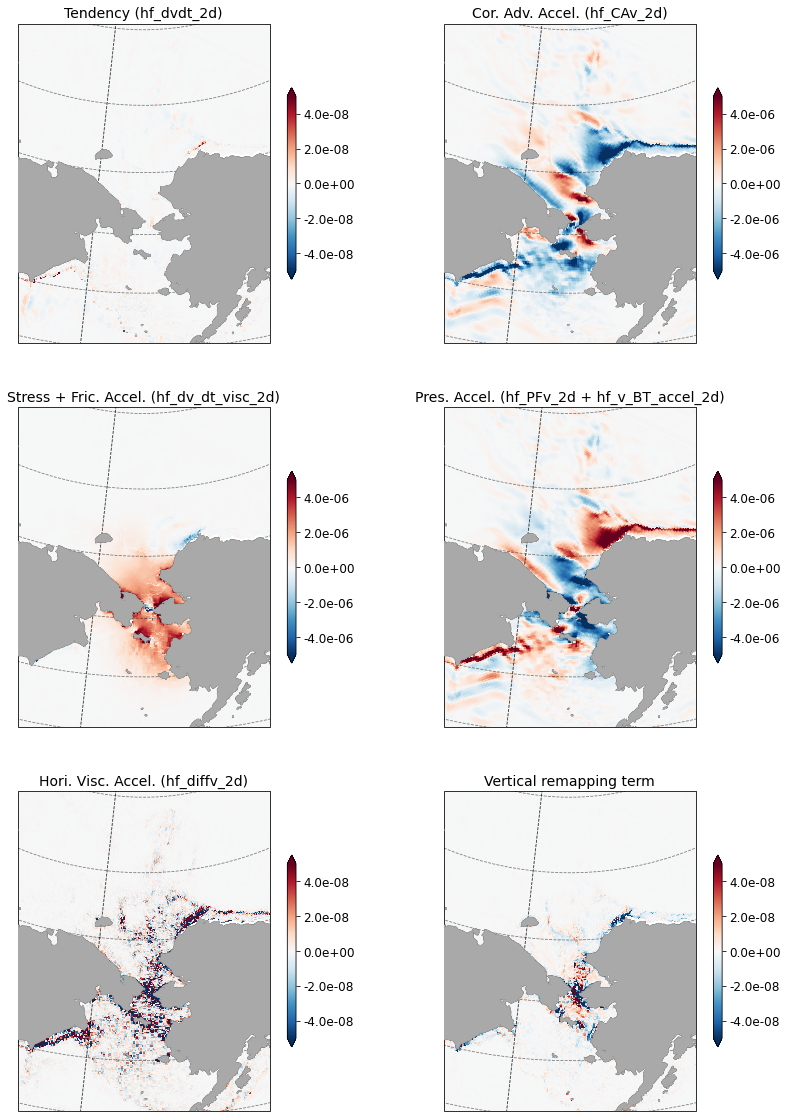

In [7]:
fig = plot_pert_budget(L66)
# save fig
fig.savefig('../figures/PerturbationExperiments/YmomBudget_pert_66N.pdf',bbox_inches='tight')

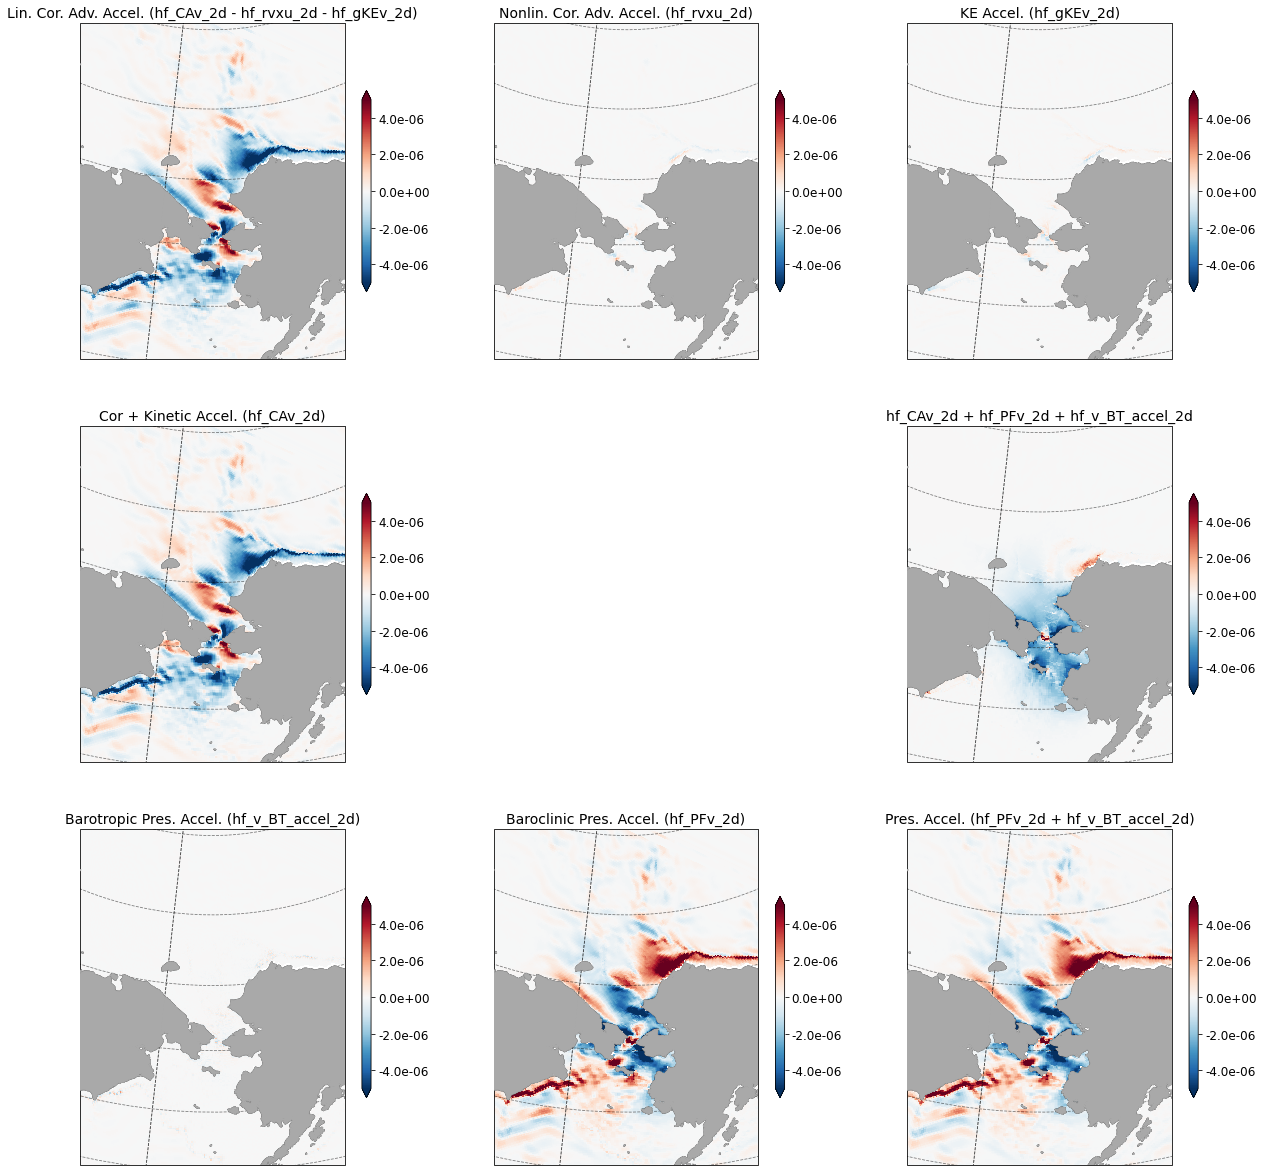

In [8]:
fig = plot_pert_CorPres(L66)
# save fig
fig.savefig('../figures/PerturbationExperiments/YmomBudget_CoriPress_pert_66N.pdf',bbox_inches='tight')

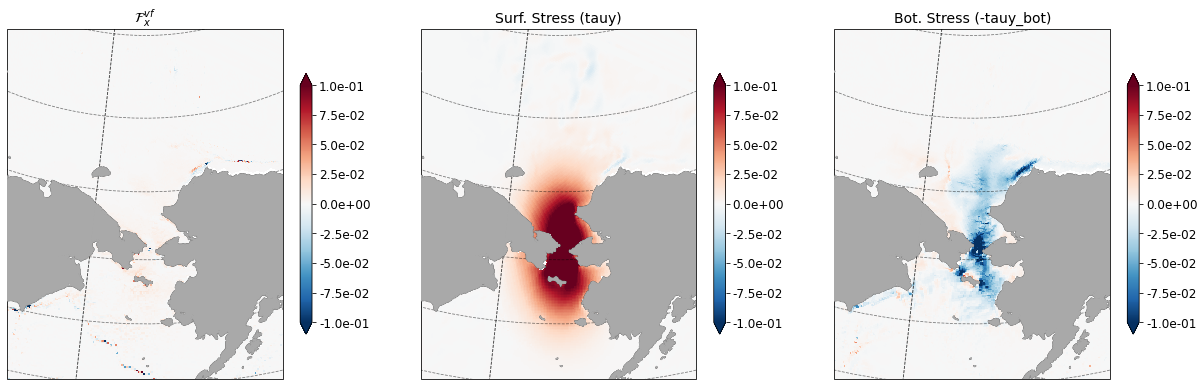

In [9]:
fig = plot_pert_stress(L66)
# save fig
fig.savefig('../figures/PerturbationExperiments/YmomBudget_Stress_pert_66N.pdf',bbox_inches='tight')

In [10]:
v10 = calc_pert('68.193_Lx300_Ly500_tau28_v10')

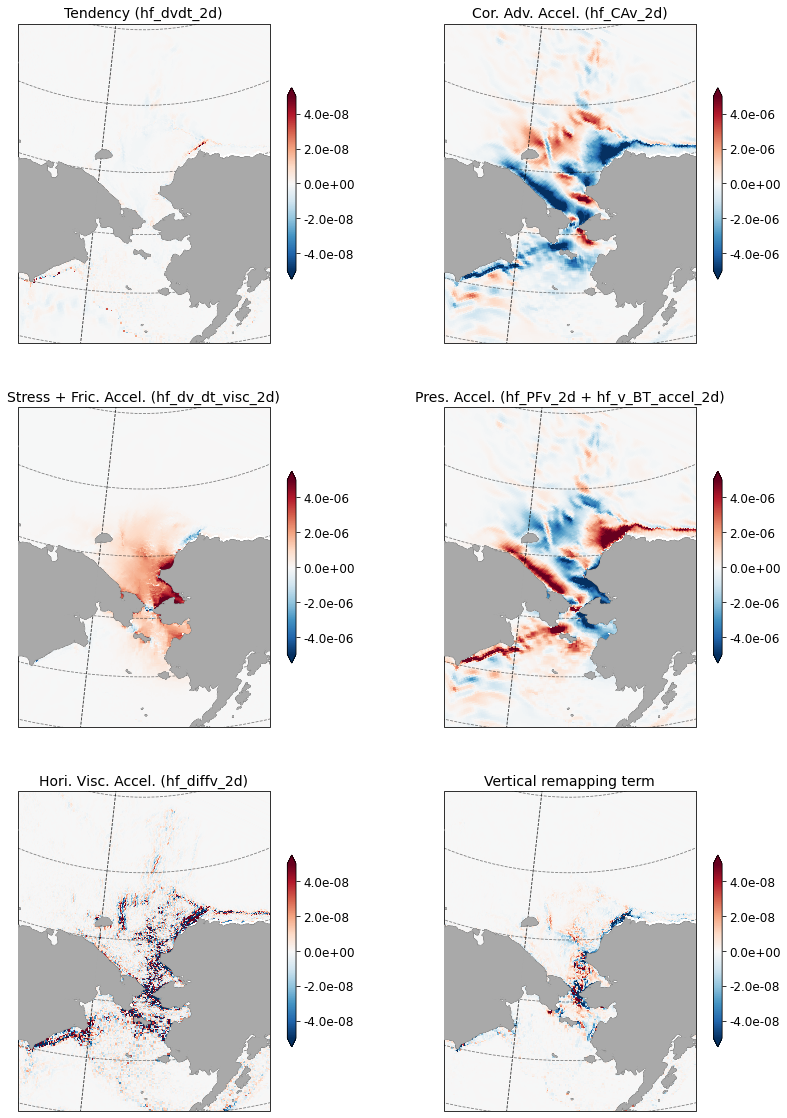

In [11]:
fig = plot_pert_budget(v10)
# save fig
fig.savefig('../figures/PerturbationExperiments/YmomBudget_pert_v10.pdf',bbox_inches='tight')

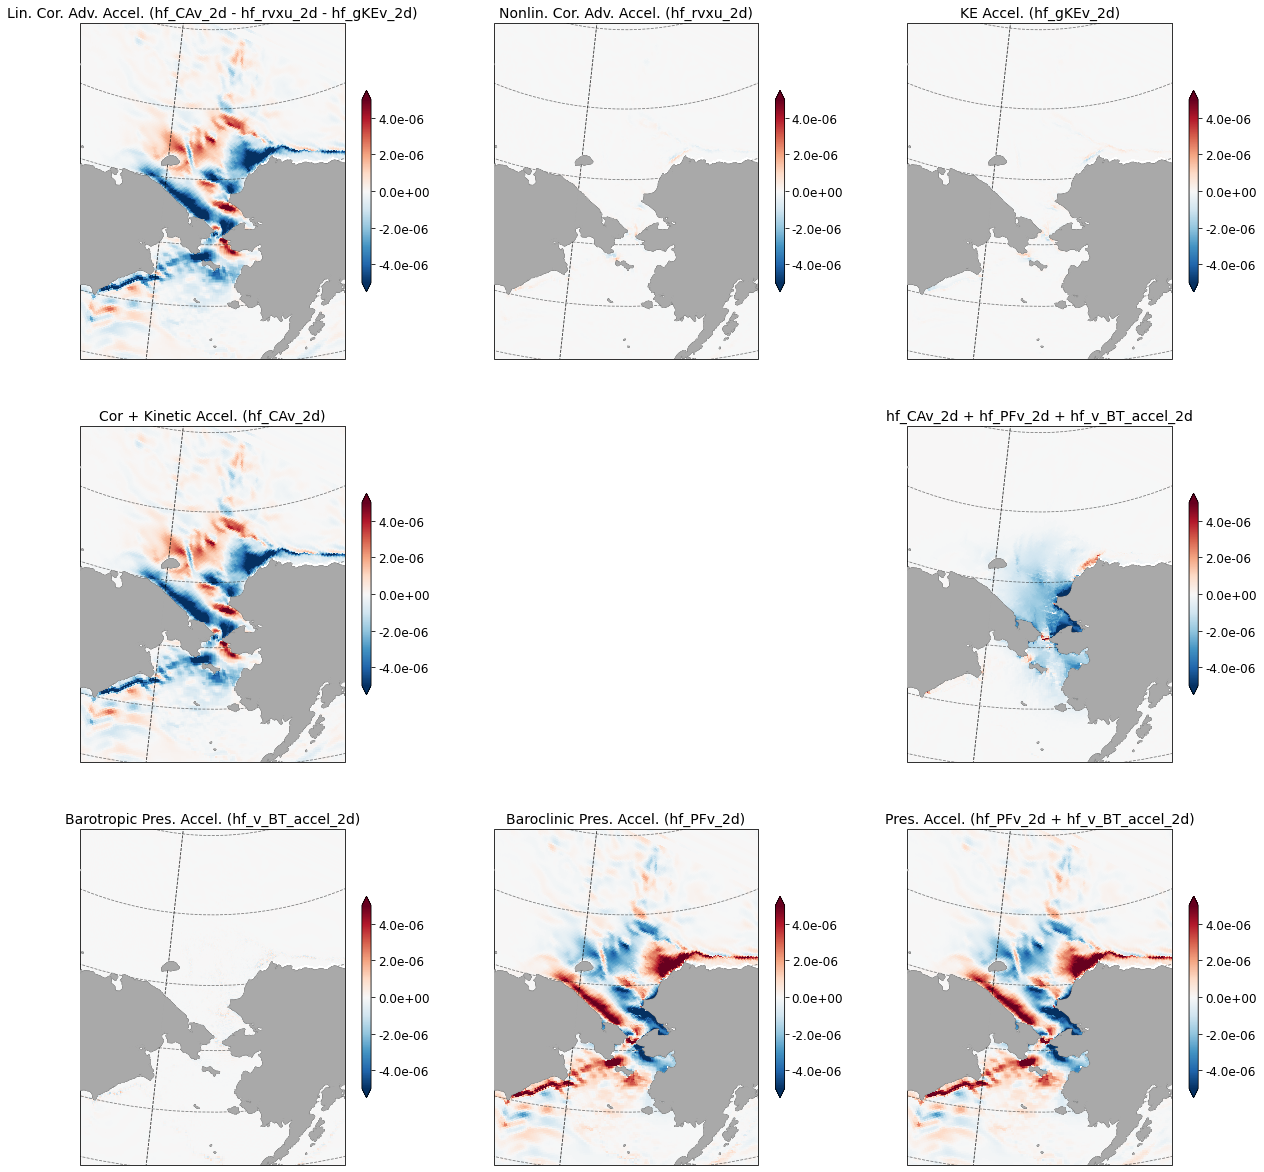

In [12]:
fig = plot_pert_CorPres(v10)
# save fig
fig.savefig('../figures/PerturbationExperiments/YmomBudget_CoriPress_pert_v10.pdf',bbox_inches='tight')

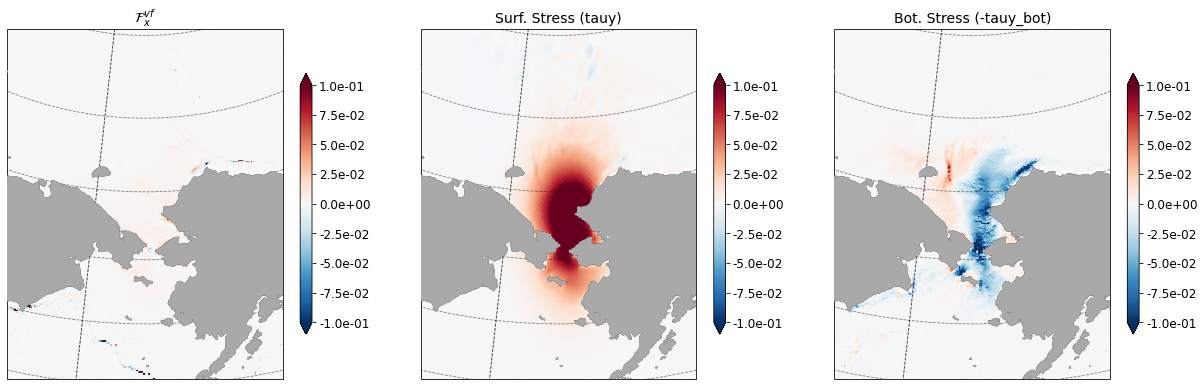

In [13]:
fig = plot_pert_stress(v10)
# save fig
fig.savefig('../figures/PerturbationExperiments/YmomBudget_Stress_pert_v10.pdf',bbox_inches='tight')